<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/XGBoost/01_Learning_Curves_XGBRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import warnings
from unicodedata import normalize

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    RepeatedKFold,
    cross_val_score)

from sklearn.metrics import mean_absolute_error


from xgboost import XGBRegressor


#**Info**
---
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: https://github.com/Kaiziferr

# **Config**
---


In [29]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
title_data = 'Materiales extraidos en Colombia'
random_seed=12354
warnings.filterwarnings("ignore")

# **Functions**
---

In [30]:
def normalize_word(word)->str:
  """Normaliza palabras"""
  word = word.replace(' ', '_')
  find_guion = word.find('_')
  list_word = []
  if find_guion:
    list_word = [w for w in word.split('_') if w != '']
  else:
    list_word = word
  word = list(map(lambda x: x.lower(), list_word))
  word = [normalize('NFKD', c).encode('ASCII', 'ignore').decode() for c in word]
  word = "_".join(word)
  return word


def normalize_name_columns(columns):
  """Normaliza columnas"""
  columns = list(map(lambda x: normalize_word(x), columns))
  return columns

def porcentaje_nulos_x_caracteristica(data:pd.DataFrame, **kwargs)->None:
  """Calcular el porcentaje de valores nulos por caracteristicas"""
  data.isnull().melt().pipe(
        lambda df: (
            sns.displot(
                data=df,
                y='variable',
                hue='value',
                multiple='fill',
                aspect=2
            ).set(**kwargs)
        )
    )

# **Data**
---

In [31]:
url_master =  'https://drive.google.com/uc?id='
url_minero='https://drive.google.com/file/d/10_YGM_dOKzzLsLNkfB_bN5YeLgDHcrUZ/view?usp=sharing'

url_minero =  url_master + url_minero.split('/')[-2]
data_miner = pd.read_csv(url_minero, dtype=str)
data_miner.head(2)

,Municipio Productor,Departamento,Recurso Natural,Nombre Del Proyecto,Año Produccion,Trimestre,Unidad Medida,Tipo Contraprestacion,Valor Contraprestacion,Cantidad Producción
0,Medellin,Antioquia,ARCILLAS,PRODUCTORES,2018,Trimestre 4,TONELADAS,REGALIAS,614258,0
1,Medellin,Antioquia,ARCILLAS CERAMICAS,PRODUCTORES,2014,Trimestre 4,TONELADAS,REGALIAS,2036781,14381


In [32]:
data_miner.columns = normalize_name_columns(data_miner.columns)

In [33]:
data_miner.columns

Index(['municipio_productor', 'departamento', 'recurso_natural',
       'nombre_del_proyecto', 'ano_produccion', 'trimestre', 'unidad_medida',
       'tipo_contraprestacion', 'valor_contraprestacion',
       'cantidad_produccion'],
      dtype='object')

In [34]:
data_miner[[
    'valor_contraprestacion',
    'cantidad_produccion']] = data_miner[[
    'valor_contraprestacion',
    'cantidad_produccion']].astype('float64')
data_miner[
    'ano_produccion'] = data_miner[
    'ano_produccion'].astype('int64')

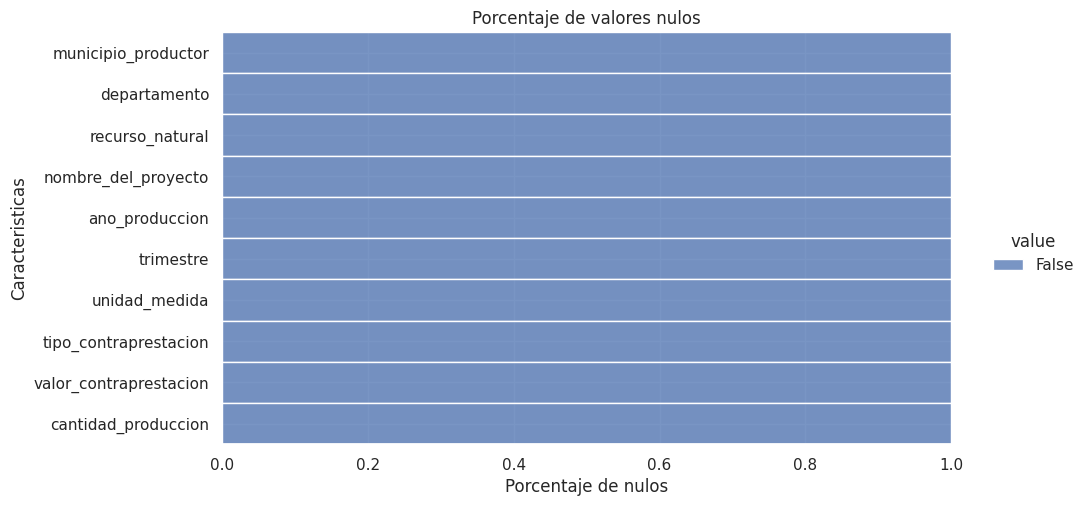

In [35]:
porcentaje_nulos_x_caracteristica(
    data_miner,
    title="Porcentaje de valores nulos",
    xlabel='Porcentaje de nulos',
    ylabel='Caracteristicas')

- No hay valores nulos

- Se tomaran los ultimos 6 años

In [36]:
data_miner = data_miner[
    (data_miner['ano_produccion'] > 2017)
    &
    (data_miner['ano_produccion'] < 2024)
]

In [37]:
data_miner['ano_produccion'].value_counts()

ano_produccion
2018    5305
2019    5133
2022    4150
2021    4141
2020    3965
2023    2355
Name: count, dtype: int64

In [38]:
data_miner.columns

Index(['municipio_productor', 'departamento', 'recurso_natural',
       'nombre_del_proyecto', 'ano_produccion', 'trimestre', 'unidad_medida',
       'tipo_contraprestacion', 'valor_contraprestacion',
       'cantidad_produccion'],
      dtype='object')

In [39]:
function_dictionary = {
    'valor_contraprestacion':['sum', 'count'],
    'cantidad_produccion': ['sum'],
}

data_transaction = data_miner.groupby([
    'municipio_productor',
    'departamento',
    'ano_produccion',
    'trimestre'
]).aggregate(
    function_dictionary
)

data_transaction.columns = [
    'valor_contraprestacion_sum',
    'n_transacciones_valor_contraprestacion',
    'valor_cantidad_produccion_sum',
]

data_transaction.reset_index(inplace=True)
data_transaction

,municipio_productor,departamento,ano_produccion,trimestre,valor_contraprestacion_sum,n_transacciones_valor_contraprestacion,valor_cantidad_produccion_sum
0,Abejorral,Antioquia,2018,Trimestre 1,"2,783,489.00",1,"52,003.00"
1,Abejorral,Antioquia,2018,Trimestre 2,"3,659,452.00",1,"52,003.00"
2,Abejorral,Antioquia,2018,Trimestre 3,"5,732,763.00",1,"81,466.00"
3,Abejorral,Antioquia,2018,Trimestre 4,"11,706,438.00",2,"108,651.00"
4,Abejorral,Antioquia,2019,Trimestre 1,"5,793,131.00",2,"67,752.00"
...,...,...,...,...,...,...,...
9912,Zona Bananera,Magdalena,2020,Trimestre 4,"65,800.00",2,452.00
9913,Zona Bananera,Magdalena,2021,Trimestre 2,"76,600.00",2,526.00
9914,utica,Cundinamarca,2020,Trimestre 4,59.00,1,0.00
9915,utica,Cundinamarca,2021,Trimestre 4,77.00,1,0.00


In [40]:
function_dictionary = {
    'valor_contraprestacion_sum':['sum', 'mean'],
    'n_transacciones_valor_contraprestacion': ['sum', 'mean'],
    'valor_cantidad_produccion_sum': ['sum', 'mean'],
    'trimestre': ['count'],
    'ano_produccion': ['nunique'],
}


data_transaction_dos = data_transaction.groupby([
    'municipio_productor',
    'departamento',
]).aggregate(
    function_dictionary
)
data_transaction_dos.columns = [
    'valor_contraprestacion_sum',
    'valor_contraprestacion_mean',
    'n_transacciones_valor_contraprestacion_sum',
    'n_transacciones_valor_contraprestacion_mean',
    'valor_cantidad_produccion_sum',
    'valor_cantidad_produccion_mean',
    'n_trimestre',
    'n_ano_produccion'
]

data_transaction_dos.reset_index(inplace=True)
data_transaction_dos

,municipio_productor,departamento,valor_contraprestacion_sum,valor_contraprestacion_mean,n_transacciones_valor_contraprestacion_sum,n_transacciones_valor_contraprestacion_mean,valor_cantidad_produccion_sum,valor_cantidad_produccion_mean,n_trimestre,n_ano_produccion
0,Abejorral,Antioquia,"54,668,833.00","4,555,736.08",18,1.50,"518,259.00","43,188.25",12,5
1,Abrego,Norte de Santander,"22,530,021.00","1,408,126.31",21,1.31,"111,626.00","6,976.62",16,5
2,Abriaqui,Antioquia,"357,383,964.00","21,022,586.12",45,2.65,"69,276.00","4,075.06",17,6
3,Acacias,Meta,"677,940,389.00","30,815,472.23",63,2.86,"3,092,471.00","140,566.86",22,6
4,Achi,Bolivar,"2,940,415,573.00","588,083,114.60",18,3.60,"361,520.00","72,304.00",5,2
...,...,...,...,...,...,...,...,...,...,...
705,Zaragoza,Antioquia,"34,398,813,794.00","1,563,582,445.18",101,4.59,"13,096,108.00","595,277.64",22,6
706,Zarzal,Valle del Cauca,"13,253,174.00","736,287.44",22,1.22,"84,672.00","4,704.00",18,6
707,Zipaquira,Cundinamarca,"3,429,252,068.00","163,297,717.52",61,2.90,"1,193,980.00","56,856.19",21,6
708,Zona Bananera,Magdalena,"2,280,457.00","380,076.17",16,2.67,"15,294.00","2,549.00",6,4


In [41]:
data_transaction_dos['id'] = data_transaction_dos.municipio_productor.str.cat(
    data_transaction_dos.departamento, sep='-'
)

data_transaction_dos = data_transaction_dos.drop(['municipio_productor', 'departamento'], axis=1)

In [42]:
data_transaction_dos = data_transaction_dos.iloc[:, ::-1]
data_transaction_dos.head(3)

,id,n_ano_produccion,n_trimestre,valor_cantidad_produccion_mean,valor_cantidad_produccion_sum,n_transacciones_valor_contraprestacion_mean,n_transacciones_valor_contraprestacion_sum,valor_contraprestacion_mean,valor_contraprestacion_sum
0,Abejorral-Antioquia,5,12,"43,188.25","518,259.00",1.50,18,"4,555,736.08","54,668,833.00"
1,Abrego-Norte de Santander,5,16,"6,976.62","111,626.00",1.31,21,"1,408,126.31","22,530,021.00"
2,Abriaqui-Antioquia,6,17,"4,075.06","69,276.00",2.65,45,"21,022,586.12","357,383,964.00"


# **Data Split**
---

In [43]:
X = data_transaction_dos.drop(['id','valor_contraprestacion_sum'], axis=1)
y = data_transaction_dos['valor_contraprestacion_sum']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=random_seed,
    test_size=0.25
)

# **Model**
---

In [45]:
model = XGBRegressor(
    n_estimators = 1000,
    max_depth = 7,
    eta = 0.1,
    subsample = 0.7,
    colsample_bytree=0.8,
)

In [46]:
cv = RepeatedKFold(
    n_splits = 10,
    n_repeats=3,
    random_state=random_seed
)
scores = cross_val_score(
    model,
    X,
    y,
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1)
scores = np.absolute(scores)

In [47]:
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 26772743897.773 (38501714784.269)


In [48]:
y.describe()

count                 710.00
mean       29,244,575,006.88
std       371,166,053,278.03
min                    77.00
25%             7,931,449.75
50%            63,407,247.50
75%         1,062,162,433.75
max     8,939,234,565,659.00
Name: valor_contraprestacion_sum, dtype: float64

In [49]:
model = XGBRegressor(
    n_estimators = 200,
    max_depth = 7,
    eta = 0.05,
    subsample = 1,
    colsample_bytree=1,
    eval_metric=mean_absolute_error
)

In [50]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eta=0.05,
             eval_metric=<function mean_absolute_error at 0x7982e27ef0a0>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [51]:
results = model.evals_result()
results.keys()

dict_keys(['validation_0', 'validation_1'])

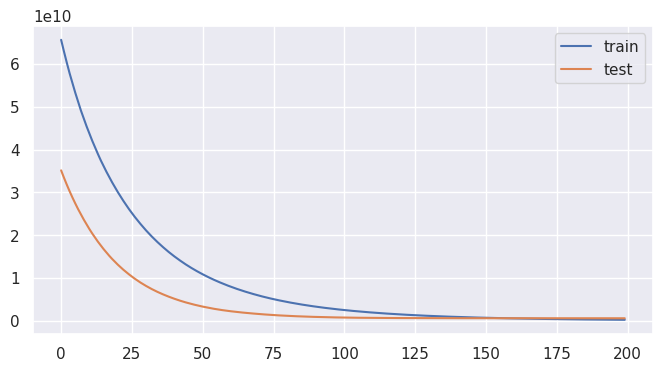

In [52]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(results['validation_0']['mean_absolute_error'], label='train')
ax.plot(results['validation_1']['mean_absolute_error'], label='test')
plt.legend()
plt.show()

In [53]:
y_predict = model.predict(X_test)

In [54]:
mean_absolute_error(y_test, y_predict)

595085322.6601124

- El modelo tiene un mejor rendimiento con la modificación de los hiperparámetros, gracias a la interpretación de las curvas de perdida.

In [55]:
model.objective

'reg:squarederror'

#**Info**
---
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: https://github.com/Kaiziferr